In [ ]:
import os
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel
from sklearn.preprocessing import MinMaxScaler
import copy
from quask.evaluator import CenteredKernelAlignmentEvaluator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

data_dir = 'TEST-DATA'

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
_service = QiskitRuntimeService(name="cotrum")
backend = _service.backend("ibm_rensselaer")
options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=options,
        backend=backend,
    )

# Instantiate a machine learning model
model = SVC(kernel='precomputed')

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
# KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
KernelFactory.set_current_implementation('qiskit_ibm')


ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=3)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=3)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=3)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=3)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=3)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=3)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=3)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=3)


kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

for fname in os.listdir(data_dir):
    if fname.endswith('.npy') and 'benign' in fname:
        benign_path = os.path.join(data_dir, fname)
        
        # Construct corresponding attack file name
        attack_fname = fname.replace('benign', 'attack')
        attack_path = os.path.join(data_dir, attack_fname)

        if os.path.exists(attack_path):
            # Load both arrays
            qX1 = np.load(benign_path)
            qX2 = np.load(attack_path)

            # select first 30 samples
            qX1 = qX1[:30]
            qX2 = qX2[:30]

            qX = np.vstack([qX1, qX2])
            qy = np.array([-1] * len(qX1) + [1] * len(qX2))


            qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.3, random_state=42)

            # reduce dimensionality
            # pca = PCA(n_components=2).fit(qX_train)
            # X_train = pca.transform(qX_train)
            # X_test = pca.transform(qX_test)
            
            # normalize data
            samples = np.append(qX_train, qX_test, axis=0)
            minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
            qX_train = minmax_scale.transform(qX_train)
            qX_test = minmax_scale.transform(qX_test)

            attack_label = attack_fname.split("attack")[0]
            
            
            
            # label_mapping = { -1: 'Benign', 1: attack_label.upper() }


            # for k in [-1, 1]:
            #     x_axis_data = qX_train[qy_train == k, 0][:400]
            #     y_axis_data = qX_train[qy_train == k, 1][:400]
            #     plt.scatter(x_axis_data, y_axis_data, label=label_mapping[k], alpha=0.5)

            # plt.title(f"{attack_label.upper()} point visualization (PCA)")
            # plt.xlabel("Component 1")
            # plt.ylabel("Component 2")
            # plt.legend()
            # plt.show()

            # # --- FIGURE 2: Zoomed on Attack region ---
            # # compute the attack bounds + padding
            # atk_mask = (qy_train == 1)
            # x_atk = qX_train[atk_mask, 0][:400]
            # y_atk = qX_train[atk_mask, 1][:400]

            # x_min, x_max = x_atk.min(), x_atk.max()
            # y_min, y_max = y_atk.min(), y_atk.max()
            # x_pad = (x_max - x_min) * 0.1
            # y_pad = (y_max - y_min) * 0.1

            # plt.figure(figsize=(6,5))
            # for k in [-1, 1]:
            #     x = qX_train[qy_train == k, 0][:400]
            #     y = qX_train[qy_train == k, 1][:400]
            #     plt.scatter(x, y, label=label_mapping[k], alpha=0.5)
            # # now zoom:
            # plt.xlim(x_min - x_pad, x_max + x_pad)
            # plt.ylim(y_min - y_pad, y_max + y_pad)

            # plt.title(f"Focused {attack_label.upper()}")
            # plt.xlabel("Component 1")
            # plt.ylabel("Component 2")
            # plt.legend()
            # plt.show()


            # OPTIMIZE KERNEL
            # from quask.optimizer.bayesian_optimizer import BayesianOptimizer
            # ce = CenteredKernelAlignmentEvaluator()
            # optimizer = BayesianOptimizer(kernel, qX_train, qy_train, ce)
            # optimized_kernel = optimizer.optimize()


            kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
            kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).
            K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data

            model.fit(K_train, qy_train)
        
            # Predict the labels for the test data
            K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
            y_pred = model.predict(K_test)

            # Calculate the accuracy
            accuracy = np.sum(qy_test == y_pred) / len(qy_test)
            print(f"Accuracy for {attack_label} is {accuracy}")
            try:
                from sklearn.metrics import classification_report
                cr = classification_report(qy_test, y_pred)
                print(cr) 
            except:
                continue


Number of circuits:  861


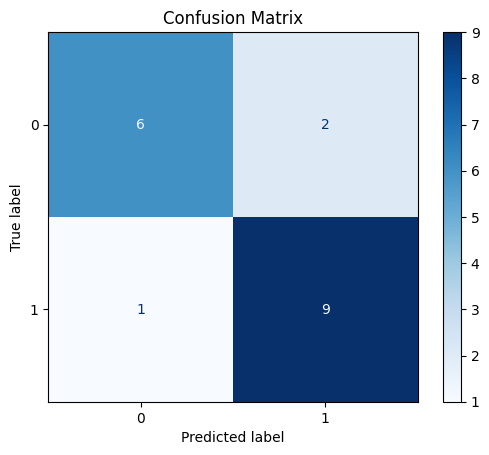

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()